In [6]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.nn.utils.rnn import pad_sequence

In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention, dim=1)


In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=0)
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_cls(embed_dim, hidden_dim, 1, dropout=dropout, batch_first=True)
        self.cell_type = cell_type

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden


In [9]:
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, enc_hidden_dim, attention, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, embed_dim, padding_idx=0)
        self.attention = attention
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_cls(embed_dim + enc_hidden_dim, hidden_dim, 1, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.cell_type = cell_type

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        if self.cell_type == 'LSTM':
            dec_hidden = hidden[0][-1]
        else:
            dec_hidden = hidden[-1]

        attn_weights = self.attention(dec_hidden, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = self.fc_out(output.squeeze(1))
        return output, hidden, attn_weights


In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, hidden_dim, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.encoder = Encoder(input_dim, embed_dim, hidden_dim, cell_type, dropout)
        self.attention = Attention(hidden_dim, hidden_dim)
        self.decoder = AttnDecoder(output_dim, embed_dim, hidden_dim, hidden_dim, self.attention, cell_type, dropout)
        self.cell_type = cell_type

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        outputs = torch.zeros(batch_size, trg_len, self.decoder.fc_out.out_features, device=src.device)
        attentions = torch.zeros(batch_size, trg_len, src.size(1), device=src.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, attn_weights = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t] = attn_weights
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs, attentions


In [21]:
########## Used function

import matplotlib.pyplot as plt
from matplotlib import font_manager

def log_attention_heatmaps_with_hindi(model, src_vocab, tgt_vocab, device, test_data, num_examples=9, font_path="/kaggle/input/nato-sans-devnagari/static/NotoSansDevanagari-Regular.ttf"):
    model.eval()
    examples = random.sample(test_data, num_examples)

    # ✅ Load the Hindi font
    hindi_font = font_manager.FontProperties(fname=font_path)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, (src_text, tgt_text) in enumerate(examples):
        src_ids = encode_sequence(src_text, src_vocab[0]) + [src_vocab[0]['<eos>']]
        trg_ids = [tgt_vocab[0]['<sos>']] + encode_sequence(tgt_text, tgt_vocab[0]) + [tgt_vocab[0]['<eos>']]

        src_tensor = torch.tensor(src_ids, device=device).unsqueeze(0)
        trg_tensor = torch.tensor(trg_ids, device=device).unsqueeze(0)

        outputs, attentions = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)

        attn = attentions[0, 1:len(trg_tensor[0])-1].detach().cpu().numpy()

        ax = axes[idx]
        im = ax.imshow(attn, aspect='auto', cmap='viridis')

        src_tokens = [src_vocab[1][i] for i in src_ids]
        trg_tokens = [tgt_vocab[1][i] for i in trg_ids[1:-1]]

        ax.set_xticks(range(len(src_tokens)))
        ax.set_xticklabels(src_tokens, fontsize=12, rotation=90, fontproperties=hindi_font)

        ax.set_yticks(range(len(trg_tokens)))
        ax.set_yticklabels(trg_tokens, fontsize=12, fontproperties=hindi_font)

        ax.set_title(f"Input: {src_text}\nTarget: {tgt_text}", fontsize=14, fontproperties=hindi_font)

    plt.tight_layout()
    wandb.log({"Attention Heatmaps Hindi": wandb.Image(fig)})
    plt.show()
    plt.close()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: nj0tsbyk
Sweep URL: https://wandb.ai/viinod9-iitm/Vinod_Assignment_3_new/sweeps/nj0tsbyk


wandb: Agent Starting Run: 9l97s5rc with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.002
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


Epoch 1/5 | Train Loss: 0.0412, Train Acc: 14.37% | Val Loss: 0.0297, Val Acc: 22.01%
Epoch 2/5 | Train Loss: 0.0256, Train Acc: 27.30% | Val Loss: 0.0265, Val Acc: 28.49%
Epoch 3/5 | Train Loss: 0.0226, Train Acc: 32.04% | Val Loss: 0.0244, Val Acc: 30.08%
Epoch 4/5 | Train Loss: 0.0212, Train Acc: 34.72% | Val Loss: 0.0252, Val Acc: 30.58%
Epoch 5/5 | Train Loss: 0.0201, Train Acc: 36.60% | Val Loss: 0.0239, Val Acc: 32.64%
Input: batlaakar | Target: बतलाकर | Prediction: बतलाकार
Input: canterbari | Target: कैंटरबरी | Prediction: कैंटरबररी
Input: lassi | Target: लस्सी | Prediction: लससि
Input: testing | Target: टेस्टिंग | Prediction: टेस्टिंग
Input: janahaani | Target: जनहानि | Prediction: जनहानी
Input: simatta | Target: सिमटता | Prediction: सिमतता
Input: putlaa | Target: पुतला | Prediction: पुलाा
Input: jhuthala | Target: झुठला | Prediction: झुठला
Input: main | Target: मैन | Prediction: मैन
Input: harem | Target: हैरम | Prediction: हरेम
Input: bairakpur | Target: बैरकपुर | Prediction

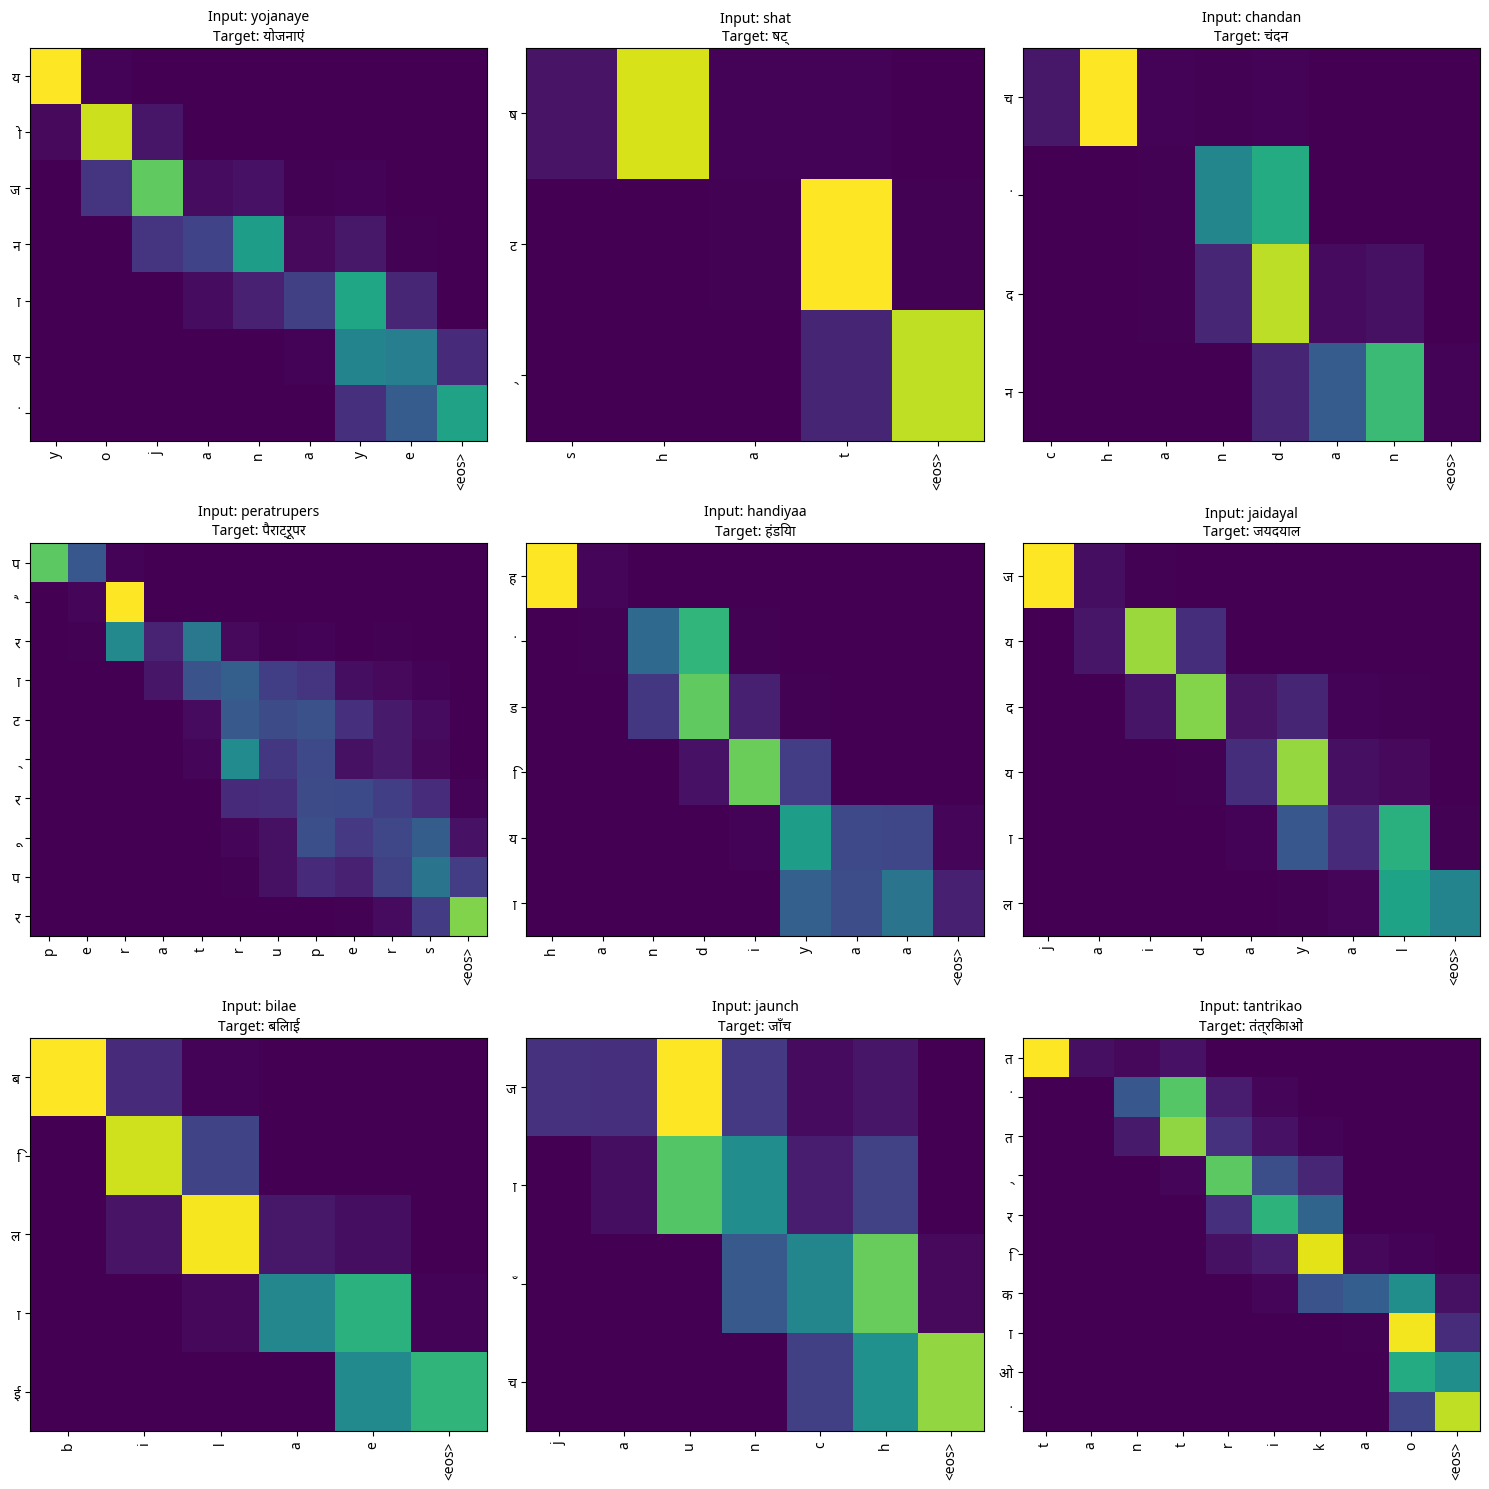

Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁
Test Word Accuracy,▁
Train Accuracy,▁▅▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▃▁
Epoch,5
Learning Rate,0.002
Teacher Forcing Ratio,0.5


In [23]:
import pandas as pd

# Log in to W&B
wandb.login(key='acdc26d2fc17a56e83ea3ae6c10e496128dee648')

# ---------- Utility Functions ----------
def build_vocab(sequences):
    chars = set(ch for seq in sequences for ch in seq)
    stoi = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    for ch in sorted(chars):
        stoi[ch] = len(stoi)
    itos = {i: ch for ch, i in stoi.items()}
    return stoi, itos

def encode_sequence(seq, stoi):
    return [stoi.get(c, stoi['<unk>']) for c in seq]

def prepare_batch(pairs, inp_stoi, out_stoi, device):
    src_seq = [torch.tensor(encode_sequence(src, inp_stoi) + [inp_stoi['<eos>']]) for src, _ in pairs]
    trg_seq = [torch.tensor([out_stoi['<sos>']] + encode_sequence(trg, out_stoi) + [out_stoi['<eos>']]) for _, trg in pairs]
    src_batch = pad_sequence(src_seq, batch_first=True, padding_value=inp_stoi['<pad>'])
    trg_batch = pad_sequence(trg_seq, batch_first=True, padding_value=out_stoi['<pad>'])
    return src_batch.to(device), trg_batch.to(device)

def read_dataset(path):
    with open(path, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
        return [(l.split('\t')[1], l.split('\t')[0]) for l in lines if '\t' in l]

def calculate_word_accuracy(preds, targets, ignore_index=0):
    # Get the token predictions
    preds = preds.argmax(dim=-1)  # [batch, seq_len]
    
    # Create a mask where targets are not padding
    mask = targets != ignore_index

    # For word-level accuracy, we check if the entire sequence matches
    # First, apply mask to both preds and targets
    preds_masked = preds * mask
    targets_masked = targets * mask

    # Now compare entire sequences
    # (preds == targets) -> shape [batch, seq_len]
    # .all(dim=1) -> True if all tokens match for a sequence
    sequence_correct = (preds_masked == targets_masked).all(dim=1)
    
    # Calculate word accuracy
    word_accuracy = sequence_correct.float().mean().item() * 100

    # print(f"Word-level Correct Sequences: {sequence_correct.sum().item()}/{sequence_correct.size(0)}")
    return word_accuracy

def calculate_word_accuracy_from_ids(preds_ids, targets_ids, ignore_index=0):
    """
    Calculates word-level accuracy given token id tensors directly (both of shape [batch, seq_len]).
    """
    # Create mask where targets are not padding
    mask = targets_ids != ignore_index

    # Mask both predictions and targets
    preds_masked = preds_ids * mask
    targets_masked = targets_ids * mask

    # Compare entire sequences: True if all tokens match in a sequence
    sequence_correct = (preds_masked == targets_masked).all(dim=1)

    # Calculate word accuracy
    word_accuracy = sequence_correct.float().mean().item() * 100

    return word_accuracy

def evaluate(model, data, src_vocab, tgt_vocab, device, criterion, batch_size):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            src, trg = prepare_batch(batch, src_vocab, tgt_vocab, device)
            output, _ = model(src, trg)
            loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))
            acc = calculate_word_accuracy(output[:, 1:], trg[:, 1:])
            total_loss += loss.item()
            total_acc += acc

    return total_loss / len(data), total_acc / (len(data) // batch_size)


# def predict_and_log_test_examples_with_attention(model, test_path, src_vocab, tgt_vocab, device, num_examples=50):
#     model.eval()
#     itos = tgt_vocab[1]
#     stoi = src_vocab[0]

#     test_data = read_dataset(test_path)
#     examples = random.sample(test_data, num_examples)
#     predictions_log = []

#     preds_list = []
#     trgs_list = []

#     for src_text, tgt_text in examples:
#         src_tensor = torch.tensor(encode_sequence(src_text, stoi) + [stoi['<eos>']], device=device).unsqueeze(0)
#         trg_tensor = torch.tensor([tgt_vocab[0]['<sos>']] + encode_sequence(tgt_text, tgt_vocab[0]) + [tgt_vocab[0]['<eos>']], device=device).unsqueeze(0)

#         # Encoder forward (returns encoder_outputs and hidden)
#         encoder_outputs, hidden = model.encoder(src_tensor)

#         # Initialize decoder input and hidden
#         input = torch.tensor([tgt_vocab[0]['<sos>']], device=device)
#         decoder_hidden = hidden

#         decoded_tokens = []
#         all_attn_weights = []

#         for _ in range(30):  # max decoding length
#             output, decoder_hidden, attn_weights = model.decoder(input, decoder_hidden, encoder_outputs)
#             top1 = output.argmax(1)
#             if top1.item() == tgt_vocab[0]['<eos>']:
#                 break
#             decoded_tokens.append(top1.item())
#             all_attn_weights.append(attn_weights.detach().cpu().numpy())
#             input = top1

#         prediction = decoded_tokens
#         pred_str = ''.join([itos[idx] for idx in prediction])

#         print(f"Input: {src_text} | Target: {tgt_text} | Prediction: {pred_str}")
#         predictions_log.append(wandb.Html(f"<b>Input:</b> {src_text} &nbsp; <b>Target:</b> {tgt_text} &nbsp; <b>Pred:</b> {pred_str}"))

#         tgt_encoded = [tgt_vocab[0].get(ch, tgt_vocab[0]['<unk>']) for ch in tgt_text] + [tgt_vocab[0]['<eos>']]
#         preds_list.append(torch.tensor(prediction, device=device))
#         trgs_list.append(torch.tensor(tgt_encoded, device=device))

#     # Find max length among predictions and targets
#     max_len = max(max([p.size(0) for p in preds_list]), max([t.size(0) for t in trgs_list]))
#     preds_padded = pad_sequence([torch.cat([p, torch.full((max_len - p.size(0),), 0, device=device)]) if p.size(0) < max_len else p for p in preds_list], batch_first=True)
#     trgs_padded = pad_sequence([torch.cat([t, torch.full((max_len - t.size(0),), 0, device=device)]) if t.size(0) < max_len else t for t in trgs_list], batch_first=True)

#     # Calculate word accuracy
#     test_word_acc = calculate_word_accuracy_from_ids(preds_padded, trgs_padded)
#     print(f"Test Word Accuracy on {num_examples} examples: {test_word_acc:.2f}%")

#     wandb.log({
#         "Test Predictions": wandb.Html("<br>".join([str(p) for p in predictions_log])),
#         "Test Word Accuracy": test_word_acc
#     })


def predict_and_log_test_examples_with_attention(model, test_path, src_vocab, tgt_vocab, device, num_examples=50, output_csv_path="predictions_attention.csv"):
    model.eval()
    itos = tgt_vocab[1]
    stoi = src_vocab[0]

    test_data = read_dataset(test_path)
    examples = random.sample(test_data, num_examples)
    predictions_log = []

    preds_list = []
    trgs_list = []
    csv_records = []  # ✅ to store results for CSV

    for src_text, tgt_text in examples:
        src_tensor = torch.tensor(encode_sequence(src_text, stoi) + [stoi['<eos>']], device=device).unsqueeze(0)
        trg_tensor = torch.tensor([tgt_vocab[0]['<sos>']] + encode_sequence(tgt_text, tgt_vocab[0]) + [tgt_vocab[0]['<eos>']], device=device).unsqueeze(0)

        encoder_outputs, hidden = model.encoder(src_tensor)

        input = torch.tensor([tgt_vocab[0]['<sos>']], device=device)
        decoder_hidden = hidden

        decoded_tokens = []
        all_attn_weights = []

        for _ in range(30):
            output, decoder_hidden, attn_weights = model.decoder(input, decoder_hidden, encoder_outputs)
            top1 = output.argmax(1)
            if top1.item() == tgt_vocab[0]['<eos>']:
                break
            decoded_tokens.append(top1.item())
            all_attn_weights.append(attn_weights.detach().cpu().numpy())
            input = top1

        prediction = decoded_tokens
        pred_str = ''.join([itos[idx] for idx in prediction])

        # ✅ Save to CSV records
        csv_records.append({
            "Input": src_text,
            "Target": tgt_text,
            "Prediction": pred_str
        })

        print(f"Input: {src_text} | Target: {tgt_text} | Prediction: {pred_str}")
        predictions_log.append(wandb.Html(f"<b>Input:</b> {src_text} &nbsp; <b>Target:</b> {tgt_text} &nbsp; <b>Pred:</b> {pred_str}"))

        tgt_encoded = [tgt_vocab[0].get(ch, tgt_vocab[0]['<unk>']) for ch in tgt_text] + [tgt_vocab[0]['<eos>']]
        preds_list.append(torch.tensor(prediction, device=device))
        trgs_list.append(torch.tensor(tgt_encoded, device=device))

    max_len = max(max([p.size(0) for p in preds_list]), max([t.size(0) for t in trgs_list]))
    preds_padded = pad_sequence([torch.cat([p, torch.full((max_len - p.size(0),), 0, device=device)]) if p.size(0) < max_len else p for p in preds_list], batch_first=True)
    trgs_padded = pad_sequence([torch.cat([t, torch.full((max_len - t.size(0),), 0, device=device)]) if t.size(0) < max_len else t for t in trgs_list], batch_first=True)

    test_word_acc = calculate_word_accuracy_from_ids(preds_padded, trgs_padded)
    print(f"Test Word Accuracy on {num_examples} examples: {test_word_acc:.2f}%")

    wandb.log({
        "Test Predictions": wandb.Html("<br>".join([str(p) for p in predictions_log])),
        "Test Word Accuracy": test_word_acc
    })

    # ✅ Save to CSV
    df = pd.DataFrame(csv_records)
    df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")



# ---------- Train Function ----------

def train():
    wandb.init(config={
        "embed_dim": 128,
        "hidden_dim": 256,
        "cell_type": "LSTM",
        "dropout": 0.2,
        "epochs": 10,
        "batch_size": 64,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "teacher_forcing_ratio": 0.5,
    })
    config = wandb.config
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    train_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
    dev_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv")

    # Build vocabs
    src_vocab, tgt_vocab = build_vocab([src for src, _ in train_data]), build_vocab([tgt for _, tgt in train_data])

    # Attention Seq2Seq model with 1 layer encoder-decoder (as per assignment requirement)
    model = Seq2Seq(len(src_vocab[0]), len(tgt_vocab[0]), config.embed_dim, config.hidden_dim,
                    config.cell_type, config.dropout).to(device)

    # Optimizer
    if config.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == "nadam":
        optimizer = optim.NAdam(model.parameters(), lr=config.learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_acc = 0
        random.shuffle(train_data)
        
        for i in range(0, len(train_data), config.batch_size):
            batch = train_data[i:i + config.batch_size]
            src, trg = prepare_batch(batch, src_vocab[0], tgt_vocab[0], device)
            
            optimizer.zero_grad()
            output, _ = model(src, trg, teacher_forcing_ratio=config.teacher_forcing_ratio)
            loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))
            acc = calculate_word_accuracy(output[:, 1:], trg[:, 1:])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc

        avg_train_loss = total_loss / len(train_data)
        avg_train_acc = total_acc / (len(train_data) // config.batch_size)
        val_loss, val_acc = evaluate(model, dev_data, src_vocab[0], tgt_vocab[0], device, criterion, config.batch_size)

        wandb.log({
            "Train Loss": avg_train_loss,
            "Train Accuracy": avg_train_acc,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_acc,
            "Epoch": epoch + 1,
            "Learning Rate": config.learning_rate,
            "Teacher Forcing Ratio": config.teacher_forcing_ratio,
        })

        print(f"Epoch {epoch + 1}/{config.epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Log attention heatmaps at the end of training
    # Load your test data
    test_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv")
    
    # Call the function to predict and log test examples + word accuracy
    predict_and_log_test_examples_with_attention(
        model=model,
        test_path="/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv",
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        device=device,
        num_examples=50,  # You can change to 9, 20 etc.
        output_csv_path="attention_predictions.csv"  # <-- desired CSV path
    )

    log_attention_heatmaps_with_hindi(
        model=model,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        device=device,
        test_data=test_data,
        num_examples=9, # Exactly 9 for 3x3 grid
        font_path="/kaggle/input/nato-sans-devnagari/static/NotoSansDevanagari-Regular.ttf"
    )

    wandb.finish()


# ---------- Sweep Setup ----------
sweep_config = {
    'method': 'random',
    'metric': {'name': 'Validation Loss', 'goal': 'minimize'},
    'parameters': {
        'embed_dim': {'values': [32, 64, 256]},
        'hidden_dim': {'values': [64, 128]},
        'enc_layers': {'values': [3]},
        'dec_layers': {'values': [3]},
        'cell_type': {'values': ['LSTM']},
        'dropout': {'values': [0.2, 0.3]},
        'batch_size': {'value': 32},
        'epochs': {'value': 5},
        'bidirectional': {'values': [False]},
        'learning_rate': {'values': [0.001, 0.002, 0.0001]},
        'optimizer': {'values': ['adam', 'nadam']},
        'teacher_forcing_ratio': {'values': [0.2, 0.5, 0.7]},
        'beam_width': {'values': [1, 3, 5]}
    }
}
# LSTM , GRU, RNN 1 3
sweep_id = wandb.sweep(sweep_config, project="Vinod_Assignment_3_new")
wandb.agent(sweep_id, function=train, count=1)